# Hate Speech Classification

In [1]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


### Import the necessary libraries

In [42]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

---
### Read the data

In [4]:
#imbalance_data = pd.read_csv("/home/jvdboss/workspace/ML_DL/Hate-Speech-Classification/archive/train.csv")

In [5]:
#imbalance_data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


---
### EDA

<AxesSubplot: xlabel='label', ylabel='count'>

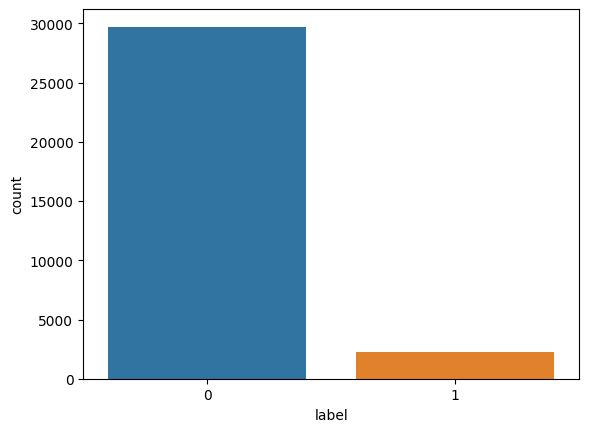

In [6]:
sns.countplot(x='label',data =imbalance_data)

From the above plot we can see that classes are imbalanced, we will fix it later.

In [7]:
# Checking the shape of the data
#data.shape

(31962, 3)

In [8]:
# Cheking if null values are present in the dataset or not.
#imbalance_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
# Let's drop the 'id' column as it is not required.
#imbalance_data.drop('id',axis=1, inplace =True)

In [3]:
# Let's load another dataset similar to our dataset, since we want to fix the imbalance data.
raw_data = pd.read_csv(r"C:\Users\NABEEL\Downloads\Hate-Speech-Classification-main\labeled_data.csv")

In [4]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [5]:
raw_data.shape

(24783, 7)

In [6]:
raw_data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [7]:
# Let's drop the columns which are not required for us.
raw_data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace =True)

In [8]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [9]:
# Let's check for the unique values in the dataset
raw_data['class'].unique()

array([2, 1, 0], dtype=int64)

<Axes: xlabel='class', ylabel='count'>

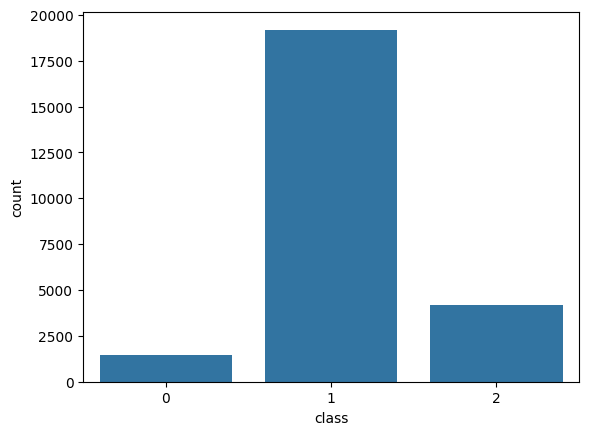

In [10]:
# Plotting the countplot for our new dataset
sns.countplot(x='class',data =raw_data)

- class 0: hate, class 1: abusive, and class 2: no hate.
- Let's copy the valus of the class 1 into class 0.

In [11]:
raw_data[raw_data['class']==0]['class']=1

C:\Users\NABEEL\AppData\Local\Temp\ipykernel_8208\3600235578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data['class']==0]['class']=1


In [12]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [13]:
raw_data['class'].unique()

array([2, 1, 0], dtype=int64)

In [15]:
# Let's check the values in the class 0
#raw_data[raw_data['class']==0]

In [16]:
# replace the value of 0 to 1
raw_data["class"].replace({0:1},inplace=True)

In [17]:
raw_data["class"].unique()

array([2, 1], dtype=int64)

<AxesSubplot: xlabel='class', ylabel='count'>

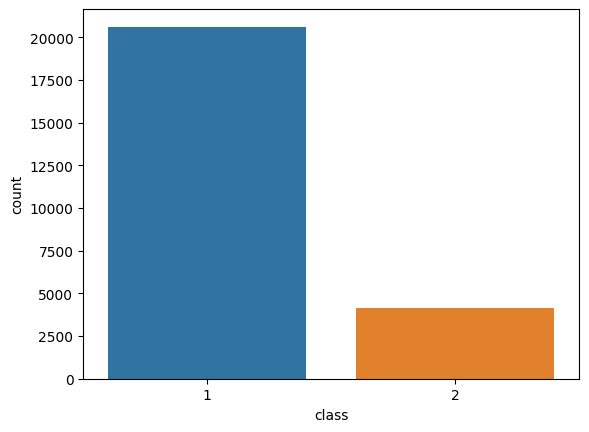

In [24]:
sns.countplot(x="class",data= raw_data)

In [18]:
# Let's replace the value of 2 to 0.
raw_data["class"].replace({2:0}, inplace = True)

<Axes: xlabel='class', ylabel='count'>

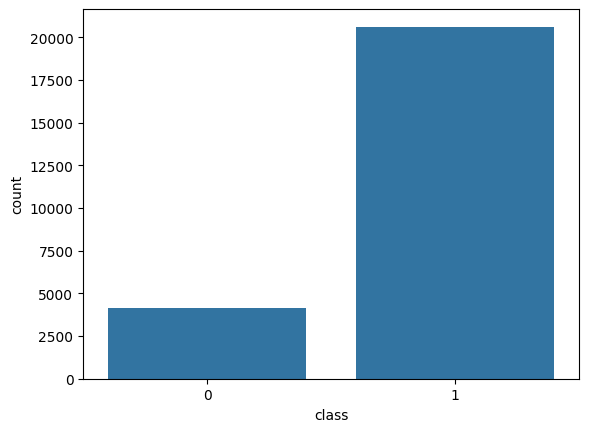

In [19]:
sns.countplot(x='class',data=raw_data)

In [20]:
# Let's change the name of the 'class' to label
raw_data.rename(columns={'class':'label'},inplace =True)

In [21]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [22]:
raw_data.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [23]:
# Let's concatinate both the data into a single data frame.
# frame = [imbalance_data, raw_data]
# df = pd.concat(frame)
df = raw_data

In [24]:
df.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


<Axes: xlabel='label', ylabel='count'>

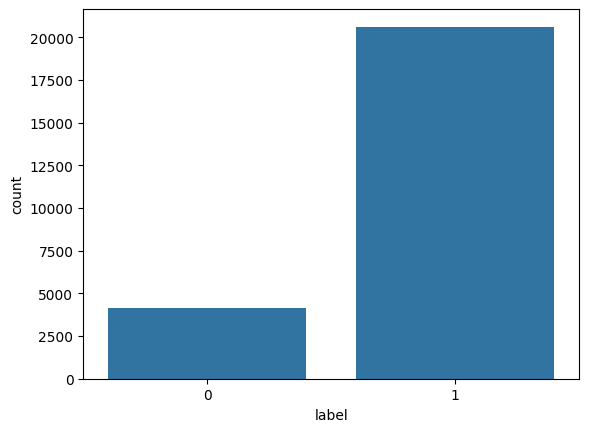

In [25]:
sns.countplot(x='label',data=df)

Now we can see that the problem of imbalace data has been solved.

In [26]:
df.shape

(24783, 2)

In [27]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [29]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [30]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [31]:
df["tweet"][3]

' rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni'

In [32]:
df.head(10)

,label,tweet
0,0,rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the tra...
1,1,rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac...
2,1,rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start ...
3,1,rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cgander...
4,1,rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts th...
5,1,tmadisonx the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes tmadisonx the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes tmadisonx the shit just blows meclaim you...
6,1,brighterdays i can not just sit up and hate on another bitch i got too much shit going on brighterdays i can not just sit up and hate on another bitch i got too much shit going on brighterdays i can not just sit up and hate on another bitch i got t...
7,1,cause im tired of you big bitches coming for us skinny cause im tired of you big bitches coming for us skinny cause im tired of you big bitches coming for us skinny cause im tired of you big bitches coming for us skinny cause im tired of you ...
8,1,amp you might not get ya bitch back amp thats that amp you might not get ya bitch back amp thats that amp you might not get ya bitch back amp thats that amp you might not get ya bitch back amp thats that amp you might not get ya bitch back am...
9,1,rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx ...


In [33]:
x = df['tweet']
y = df['label']

In [34]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

18587 18587
6196 6196


In [35]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [36]:
len(x_test)

6196

In [37]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [43]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(loss='binary_crossentropy',optimizer=adam_opt,metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 300, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# starting model training RMSprop()
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,
                   validation_split=0.2)#,callbacks=[stop,checkpoint])

117/117 [==============================] - 373s 3s/step - loss: 0.2922 - accuracy: 0.8867 - val_loss: 0.1462 - val_accuracy: 0.9411


In [44]:
# starting model training with adam
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,
                   validation_split=0.2)#,callbacks=[stop,checkpoint])

117/117 [==============================] - 391s 3s/step - loss: 0.3006 - accuracy: 0.8800 - val_loss: 0.1446 - val_accuracy: 0.9432


In [45]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [46]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

194/194 [==============================] - 25s 128ms/step - loss: 0.1638 - accuracy: 0.9324


In [47]:
lstm_prediction = model.predict(test_sequences_matrix)

194/194 [==============================] - 22s 110ms/step


In [48]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)
        

In [49]:
print(confusion_matrix(y_test,res))

[[ 894  147]
 [ 272 4883]]


In [50]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
# Let's save the mdoel.
model.save("model.h5")

c:\Users\NABEEL\Anaconda3\envs\DLNLP\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
import keras

In [53]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [55]:
# Let's test our model on custom data.
test = 'mostly probelm is because of black people only'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")
    

mostly probelm is because of black people only
mostly probelm is because of black people only
['most probelm black peopl']
[[235, 176, 1705]]
1/1 [==============================] - 0s 106ms/step
pred [[0.2266973]]
no hate
